In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
plt.rc('ps', useafm=True)
plt.rc('pdf', use14corefonts=True)

In [2]:
# only use the table_final wayids
table_final = pd.read_csv('speed_cdf_stats_select_final.csv', index_col=0)
table_final

,num_samples,min_speed,s1,s2,max_speed,s1_cumfrac,s2_cumfrac,r_squared,s2_s1_cumfrac_diff
wayid,,,,,,,,,
640073514,11524.0,0.6,13.8,30.1,63.7,0.2206,0.9709,0.999,0.7503
673365543,113.0,9.6,14.8,22.6,31.2,0.1504,0.9009,0.998,0.7505
267252124,1251.0,6.6,36.4,55.7,79.9,0.2045,0.9551,0.999,0.7506
25850274,1259.0,2.5,12.8,21.3,59.1,0.1620,0.9139,0.997,0.7519
24027794,16426.0,1.6,28.1,45.8,71.5,0.2338,0.9860,0.998,0.7522
...,...,...,...,...,...,...,...,...,...
311725584,15363.0,2.2,10.4,35.4,62.7,0.0043,0.9893,0.997,0.9850
698498913,16476.0,8.0,15.5,57.2,81.1,0.0012,0.9866,0.997,0.9854
4962801,17353.0,8.4,20.0,56.8,77.5,0.0082,0.9962,0.996,0.9880


<AxesSubplot:>

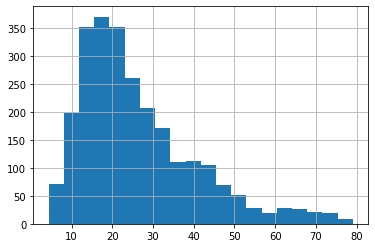

In [3]:
table_final.s1.hist(bins=20)

In [18]:
# compute traffic jam stats
plt.rc('font', size=12)

def compute_jam_stats(save_suffix, interp_lim=None, s1_arg=None):
    # save_suffix: some suffix for saving output files (cannot be empty string)
    # interp_lim: 2 or 3 or something else (interpolation limit to be passed to pd.DataFrame.interpolate)
    # s1_arg: what value of s1 to use (if None, use s1 of each segment individually)
    
    assert len(save_suffix) > 0
    assert (interp_lim is None) or (isinstance(interp_lim, int) and (interp_lim > 0))
    assert (s1_arg is None) or (s1_arg > 0)

    fout = open('jam_stats_{}.csv'.format(save_suffix), 'w')
    fout.write('wayid,n_jams,total_hours,min_hours,max_hours,n_max_hours,mean_hours,median_hours,mode_hours,modes_hour_of_day,modes_num_instances' + os.linesep)

    savedir = '../jam_stats_{}/'.format(save_suffix)
    if not os.path.exists(savedir):
        os.makedirs(savedir)

    t_index = pd.date_range(start='1/1/2018', end='1/1/2020', freq='1H', closed='left')
    
    s1 = s1_arg

    data_dir = '/home/shivar/Research/traffic/traffic_jams/data/per-segment/'
    for wayid in tqdm(table_final.index, desc='interp_lim: {}, s1: {}'.format(interp_lim, s1_arg)):
        #wayid = 48958915

        data = pd.read_csv(data_dir + '{}.csv'.format(wayid), usecols=[1,2], index_col=0, parse_dates=True)
        data = data.tz_localize(None, copy=False) # remove time zone info
        data = data.reindex(t_index).interpolate(method='linear', limit=interp_lim)

        if s1_arg is None:
            s1 = table_final.s1.loc[wayid] # use the s1 for this particular segment, rather than population average
            #s1 = 20 # this is a lower bound on s1
        data['jam'] = np.nan
        data.loc[data.speed_kph_mean < s1, 'jam'] = 1.0
        data.loc[data.speed_kph_mean >= s1, 'jam'] = 0.0
        #data['jam'] = (data.speed_kph_mean < s1) # this is the definition of a jam

        # now count the number of times the jam occurs
        jams = [] # list of tuples -- (# hours, start time of jam, end time of jam)
        #state = data.jam.iloc[0]
        #s_dt = data.jam.index[0] if state else None
        state = False
        s_dt = None
        for ts, val in data.jam.iteritems():
            if (not state) and val == 1.0:
                # entering a jam when jam bit is 1 and state is False
                s_dt = ts
                state = True
            elif state and ((val == 0.0) or np.isnan(val)):
                # exiting a jam when jam bit is 0 or NaN and state is True
                hh = (ts - s_dt).total_seconds() / 3600.0
                jams.append((s_dt, ts, hh))
                state = False

        if len(jams) == 0:
            continue

        jams_df = pd.DataFrame(jams, columns=['start_time', 'end_time', 'hours_in_jam'])
        jams_df.set_index('start_time', inplace=True)
        jams_df.to_csv(savedir + '{}.csv'.format(wayid))
        fig = plt.figure()
        ax = fig.add_subplot(111)
        jams_df.hours_in_jam.hist(ax=ax, bins=np.arange(25))
        ax.set_xlabel('Hours in jam')
        ax.set_ylabel('Number of jam instances')
        fig.tight_layout()
        fig.savefig(savedir + '{}.png'.format(wayid), facecolor='white')
        plt.close(fig)

        # stats
        # wayid,n_jams,total_hours,min_hours,max_hours,mean_hours,median_hours,modes_hours,modes_hour_of_day,modes_num_instances
        total_hours = jams_df.hours_in_jam.sum()
        min_hours = jams_df.hours_in_jam.min()
        max_hours = jams_df.hours_in_jam.max()
        n_max_hours = (jams_df.hours_in_jam.values == max_hours).sum()
        mean_hours = jams_df.hours_in_jam.mean()
        median_hours = jams_df.hours_in_jam.median()
        modes_hours = jams_df.hours_in_jam.mode().to_list()
        modes_hour_of_day = stats.mode(jams_df.index.hour)
        fout.write('{},{},{:.0f},{:.0f},{:.0f},{},{:.1f},{:.1f},\"{}\",\"{}",\"{}"'.format(wayid, len(jams), total_hours, min_hours, max_hours, n_max_hours, mean_hours, median_hours, modes_hours, modes_hour_of_day.mode, modes_hour_of_day.count) + os.linesep)

    fout.close()
    return

In [19]:
compute_jam_stats('interplim_3_s1_17', interp_lim=3)

interp_lim: 3, s1: None: 100%|██████████| 2590/2590 [07:44<00:00,  5.58it/s]


In [9]:
#compute_jam_stats('interplim_2_s1cap_20', interp_lim=2)

interp_lim: 2, s1: None: 100%|██████████| 2590/2590 [08:24<00:00,  5.14it/s]


In [10]:
#compute_jam_stats('interplim_3_s1cap_20', interp_lim=3)

interp_lim: 3, s1: None: 100%|██████████| 2590/2590 [08:19<00:00,  5.18it/s] 


In [6]:
#compute_jam_stats('interplim_2_s1_20', interp_lim=2, s1_arg=20)

interp_lim: 2, s1: 20: 100%|██████████| 2590/2590 [07:29<00:00,  5.76it/s]


In [7]:
#compute_jam_stats('interplim_3', interp_lim=3)

interp_lim: 3, s1: None: 100%|██████████| 2590/2590 [07:43<00:00,  5.59it/s]


In [8]:
#compute_jam_stats('interplim_3_s1_20', interp_lim=3, s1_arg=20)

interp_lim: 3, s1: 20: 100%|██████████| 2590/2590 [07:29<00:00,  5.77it/s] 


Number of jams: 676
Min hours in jam: 1.0
Max hours in jam: 10.0
Avg hours in jam: 2.039940828402367
Median hours in jam: 1.0
min_speed     5.6
max_speed    86.2
s1           32.9
Name: 100126230, dtype: float64


<AxesSubplot:>

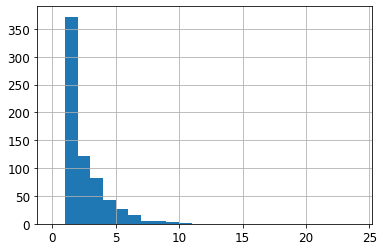

In [5]:
wayid = 100126230
jams_df = pd.read_csv('../jam_stats_interplim_2/{}.csv'.format(wayid), index_col=0)
print('Number of jams:', jams_df.shape[0])
print('Min hours in jam:', jams_df.hours_in_jam.min())
print('Max hours in jam:', jams_df.hours_in_jam.max())
print('Avg hours in jam:', jams_df.hours_in_jam.mean())
print('Median hours in jam:', jams_df.hours_in_jam.median())
print(table_final.loc[wayid, ['min_speed', 'max_speed', 's1']])
jams_df.hours_in_jam.hist(bins=np.arange(25))

In [20]:
def print_plot_stats(fpath, wayids_list=None, extra_suffix=''):
    plt.rc('font', size=20)
    
    table = pd.read_csv(fpath, index_col=0)
    if wayids_list is not None:
        table = table.loc[wayids_list] # used to get the stats only for a cluster
    table.sort_values('total_hours', inplace=True, ascending=False)
    
    # creating file for writing report
    if len(extra_suffix) > 0:
        extra_suffix = '_' + extra_suffix
    fout = open(os.path.splitext(fpath)[0] + '{}_report.txt'.format(extra_suffix), 'w')
    
    # expecting file name to be of the form "jam_stats_xyz.csv" (xyz is the suffix being extracted)
    suffix = os.path.basename(os.path.splitext(fpath)[0]).split('_', 2)[2]
    fig_save_suffix = (suffix + extra_suffix).replace('_', '-') # for latex
    
    # total hours in jam
    total_total_hours = table.total_hours.sum()
    print('Total number of hours in jams by all the traffic in Nairobi: {}'.format(total_total_hours), file=fout, flush=True)
    print('Number of hours in jams by the traffic per day in Nairobi: {:.1f}'.format(total_total_hours/730.0), file=fout, flush=True)
    mean_total_hours = table.total_hours.mean()
    title_str = 'On avg {:.1f} hours over 2 years = {:.1f} hours per day'.format(mean_total_hours, mean_total_hours/730.0)
    print(title_str, file=fout, flush=True)

    plt.figure(figsize=(10,6))
    table.total_hours.hist(bins=20)
    plt.title(title_str)
    plt.xlabel('Hours', labelpad=10)
    plt.ylabel('Bin count', labelpad=10)
    plt.tight_layout()
    plt.savefig('../figures/total-jam-hours-{}.pdf'.format(fig_save_suffix))
    plt.close()
    
    # min, mean, median and max hours in jam - TODO
    
    # mode hours in jam
    mode_hours_all = sum(map(eval, table.mode_hours.values), [])
    mode_hours_bincount = np.bincount(mode_hours_all)
    print('Mode hours bincount:', file=fout)
    barx = np.arange(len(mode_hours_bincount))
    np.savetxt(fout, np.hstack((barx[:,np.newaxis], mode_hours_bincount[:,np.newaxis])), delimiter=',', fmt='%d')
    fout.flush()
    plt.figure(figsize=(8,4))
    plt.bar(np.arange(len(mode_hours_bincount)), mode_hours_bincount, color='m')
    plt.xlabel('Most frequently occurring jam durations')
    plt.ylabel('Histogram')
    plt.tight_layout()
    plt.savefig('../figures/mode-hours-bincount-{}.pdf'.format(fig_save_suffix))
    plt.close()
    
    # mode hour of day & number of instances
    mode_hourofday_all = sum(map(eval, table.modes_hour_of_day), [])
    mode_hourofday_count_all = sum(map(eval, table.modes_num_instances), [])
    mode_hourofday_df = pd.DataFrame(np.vstack((mode_hourofday_all, mode_hourofday_count_all)).T, 
                                     columns=['mode_hour_of_day', 'mode_hour_of_day_count'])
    mode_hourofday_counttotal_df = mode_hourofday_df.groupby('mode_hour_of_day').sum()
    mode_hourofday_counttotal_df = mode_hourofday_counttotal_df.reindex(np.arange(24))
    
    plt.figure(figsize=(10,5))
    mode_hourofday_counttotal_df.mode_hour_of_day_count.plot(kind='bar', color='c')
    print('Mode hour of day:', file=fout)
    np.savetxt(fout, mode_hourofday_counttotal_df.reset_index().values, delimiter=',', fmt='%.0f')
    plt.xlabel('Hour of day')
    plt.ylabel('Number of occurrences')
    plt.tight_layout()
    plt.savefig('../figures/mode-hourofday-{}.pdf'.format(fig_save_suffix))
    plt.close()
    
    fout.close()

In [21]:
cluster_labels = pd.read_csv('../clustering/cluster_labels_k3_rand0.csv', index_col=0)
cluster_labels

,cluster_label
osm_way_id,
4685092,2
4716859,0
4716860,1
4716862,1
4716873,0
...,...
686119501,0
687425391,1
687425392,0


In [22]:
cluster0_labels = cluster_labels.index[cluster_labels.cluster_label == 0]
cluster0_labels

Int64Index([  4716859,   4716873,   4723375,   4723967,   4723976,   4723980,
              4724000,   4724002,   4724007,   4724019,
            ...
            680915360, 681098568, 681098570, 681099272, 683045286, 683045287,
            683045288, 686119501, 687425392, 687425393],
           dtype='int64', name='osm_way_id', length=1029)

In [23]:
cluster0_labels.intersection(table_final.index)

Int64Index([  4716859,   4716873,   4723375,   4723967,   4723976,   4723980,
              4724000,   4724002,   4724007,   4724019,
            ...
            680915356, 680915358, 680915359, 680915360, 681098568, 681098570,
            681099272, 683045286, 683045287, 683045288],
           dtype='int64', length=941)

In [9]:
print_plot_stats('jam_stats_interplim_3_s1_20.csv', cluster0_labels.intersection(table_final.index), 'cluster0')

In [10]:
cluster1_labels = cluster_labels.index[cluster_labels.cluster_label == 1]
print_plot_stats('jam_stats_interplim_3_s1_20.csv', cluster1_labels.intersection(table_final.index), 'cluster1')

cluster2_labels = cluster_labels.index[cluster_labels.cluster_label == 2]
print_plot_stats('jam_stats_interplim_3_s1_20.csv', cluster2_labels.intersection(table_final.index), 'cluster2')

KeyError: '[25761267, 43159844, 48850475, 162817955, 162818140, 162818143, 183810314, 231490823, 231493753, 231493757, 231493758, 231493764, 231503844, 231933978, 247463758, 312906757, 332245951, 336024451, 337522388, 345017135, 367956920, 369117815, 415494870, 419291440, 432316784, 436796431, 436796433, 472115189, 567085651, 567085668, 583039634, 655547440, 655574382, 658273335, 679519425, 680875540] not in index'

In [48]:
print_plot_stats('jam_stats_interplim_2.csv')
print_plot_stats('jam_stats_interplim_2_s1_20.csv')
print_plot_stats('jam_stats_interplim_3.csv')
print_plot_stats('jam_stats_interplim_3_s1_20.csv')

In [24]:
print_plot_stats('jam_stats_interplim_3_s1_17.csv', cluster0_labels.intersection(table_final.index), 'cluster0')

In [25]:
cluster1_labels = cluster_labels.index[cluster_labels.cluster_label == 1]
print_plot_stats('jam_stats_interplim_3_s1_17.csv', cluster1_labels.intersection(table_final.index), 'cluster1')

cluster2_labels = cluster_labels.index[cluster_labels.cluster_label == 2]
print_plot_stats('jam_stats_interplim_3_s1_17.csv', cluster2_labels.intersection(table_final.index), 'cluster2')

In [26]:
print_plot_stats('jam_stats_interplim_2_s1_17.csv')

In [12]:
table_jam_stats = pd.read_csv('jam_stats_interplim_3_s1_17.csv', index_col=0)
table_jam_stats.sort_values('total_hours', inplace=True, ascending=False)
table_jam_stats

,n_jams,total_hours,min_hours,max_hours,mean_hours,median_hours,mode_hours,modes_hour_of_day,modes_num_instances
wayid,,,,,,,,,
24027794,1114,4598,1,13,4.1,3.0,[1.0],[11],[182]
678327891,1379,4205,1,19,3.0,2.0,[1.0],[17],[110]
231502880,975,4192,1,16,4.3,5.0,[1.0],[16],[300]
567085634,1081,4165,1,11,3.9,4.0,[1.0],[16],[261]
112950524,1292,4146,1,14,3.2,3.0,[3.0],[6],[409]
...,...,...,...,...,...,...,...,...,...
287710521,2,6,3,3,3.0,3.0,[3.0],[14],[1]
678331193,2,6,3,3,3.0,3.0,[3.0],[18],[1]
26744322,3,6,1,3,2.0,2.0,"[1.0, 2.0, 3.0]",[15],[1]


In [12]:
table_jam_stats = pd.read_csv('jam_stats_interplim_2.csv', index_col=0)
table_jam_stats.sort_values('total_hours', inplace=True, ascending=False)
table_jam_stats

,n_jams,total_hours,min_hours,max_hours,mean_hours,median_hours,mode_hours,modes_hour_of_day,modes_num_instances
wayid,,,,,,,,,
24027794,1114,4598,1,13,4.1,3.0,[1.0],[11],[182]
678327891,1379,4205,1,19,3.0,2.0,[1.0],[17],[110]
231502880,975,4192,1,16,4.3,5.0,[1.0],[16],[300]
567085634,1081,4165,1,11,3.9,4.0,[1.0],[16],[261]
112950524,1292,4146,1,14,3.2,3.0,[3.0],[6],[409]
...,...,...,...,...,...,...,...,...,...
287710521,2,6,3,3,3.0,3.0,[3.0],[14],[1]
678331193,2,6,3,3,3.0,3.0,[3.0],[18],[1]
26744322,3,6,1,3,2.0,2.0,"[1.0, 2.0, 3.0]",[15],[1]


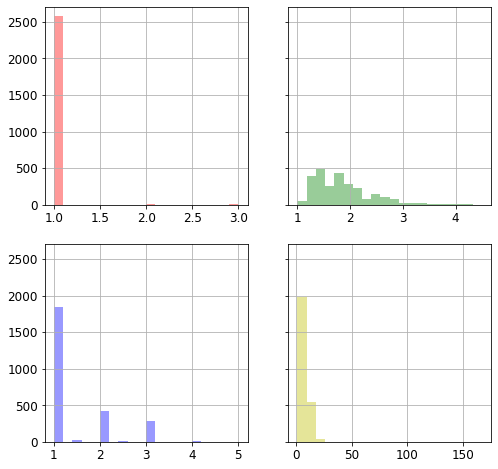

In [17]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(8,8))
nbins = 20
table_jam_stats.min_hours.hist(ax=axs.flat[0], bins=nbins, color='r', alpha=0.4, label='Min hours in jam')
table_jam_stats.mean_hours.hist(ax=axs.flat[1], bins=nbins, color='g', alpha=0.4, label='Mean hours in jam')
table_jam_stats.median_hours.hist(ax=axs.flat[2], bins=nbins, color='b', alpha=0.4, label='Median hours in jam')
table_jam_stats.max_hours.hist(ax=axs.flat[3], bins=nbins, color='y', alpha=0.4, label='Max hours in jam')
plt.show()

In [18]:
mode_hours_all = sum(map(eval, table_jam_stats.mode_hours.values), [])

In [19]:
set(mode_hours_all)

{1.0, 2.0, 3.0, 4.0, 5.0}

[   0 2322    5  272    3    4]


<BarContainer object of 6 artists>

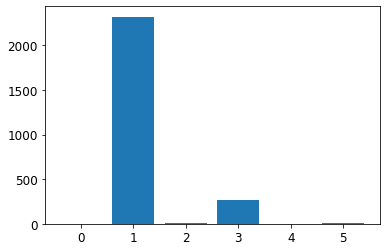

In [23]:
mode_hours_bincount = np.bincount(mode_hours_all)
print(mode_hours_bincount)
plt.bar(np.arange(len(mode_hours_bincount)), mode_hours_bincount)

In [24]:
# mode hour of day
mode_hourofday_all = sum(map(eval, table_jam_stats.modes_hour_of_day), [])
mode_hourofday_ninst_all = sum(map(eval, table_jam_stats.modes_num_instances), [])

In [25]:
set(mode_hourofday_all)

{0, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}

In [32]:
mode_hourofday_df = pd.DataFrame(np.vstack((mode_hourofday_all, mode_hourofday_ninst_all)).T, columns=['mode_hour_of_day', 'mode_hour_of_day_count'])
mode_hourofday_df

,mode_hour_of_day,mode_hour_of_day_count
0,11,182
1,17,110
2,16,300
3,16,261
4,6,409
...,...,...
2585,14,1
2586,18,1
2587,15,1
2588,14,1


In [33]:
mode_hourofday_counttotal_df = mode_hourofday_df.groupby('mode_hour_of_day').sum()
mode_hourofday_counttotal_df = mode_hourofday_counttotal_df.reindex(np.arange(24))
mode_hourofday_counttotal_df

,mode_hour_of_day_count
mode_hour_of_day,
0,328.0
1,NaN
2,52.0
3,NaN
4,NaN
5,941.0
6,16846.0
7,41685.0
8,5115.0


<AxesSubplot:xlabel='mode_hour_of_day'>

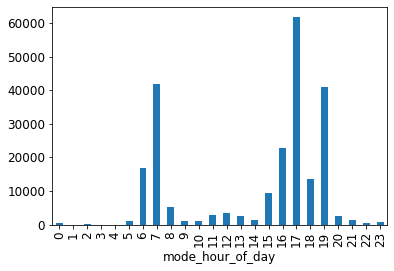

In [35]:
mode_hourofday_counttotal_df.mode_hour_of_day_count.plot(kind='bar')